In [2]:
# set the working directory to be the root of the package
# so that the imports work below
import sys
sys.path.append("..")

In [3]:
import numpy as np
import pandas as pd
import sklearn as skl
from sklearn.decomposition import KernelPCA, IncrementalPCA
import matplotlib.pyplot as plt
import models.data_util
import seaborn
import random
from models.data_util import get_col_matcher
from models.feature_util import date_cols

In [4]:
data_file = "../data/full.pkl"  # set this accordingly

db = pd.read_pickle(data_file)

# Load the lat/long for each company
x = db[['lat', 'long']].to_numpy()
y = db['isfailed'].to_numpy().reshape((-1,))

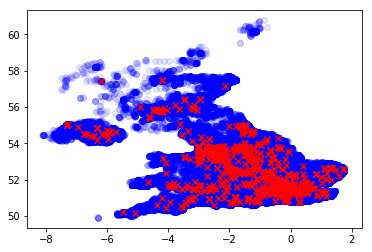

In [5]:
# plot the lat/long of all companies in the dataset:

failedcomps = np.nonzero(y == 1)
notfailedcomps = np.nonzero(y == 0)

# transpose is needed to make the UK look upright!
plt.scatter(x[notfailedcomps].T[1], x[notfailedcomps].T[0],
            marker='o', alpha=0.1, color='blue')
plt.scatter(x[failedcomps].T[1], x[failedcomps].T[0],
            marker='x', alpha=1.0, color='red')
plt.show()

In [6]:
# file path of a cleaned data file (so we can see the difference
# to lat/long)

cleaned_data_file = "../data/clean.pkl"  # set this accordingly

clean_data = pd.read_pickle(cleaned_data_file)

In [7]:
clean_db_failed = clean_data[clean_data['isfailed'] == 1]
clean_db_notfailed = clean_data[clean_data['isfailed'] == 0]

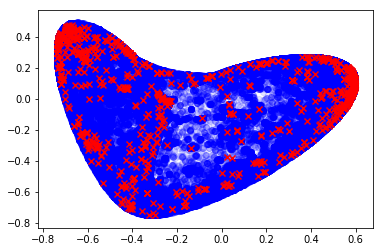

In [8]:
# plot the lat/long of the companies in the cleaned dataset, which has had
# PCA applied to the positions:

plt.scatter(clean_db_notfailed['pos1'].to_numpy(), clean_db_notfailed['pos2'].to_numpy(),
            marker='o', alpha=0.1, color='blue')
plt.scatter(clean_db_failed['pos1'].to_numpy(), clean_db_failed['pos2'].to_numpy(),
            marker='x', alpha=1.0, color='red')
plt.show()

In [9]:
# Now let's examine the following accounting fields:
# Field2267, Field2816, Field972, Field477, Field2823
# These are pesky because they don't have a corresponding hasFN field
# and some of the fields contain strings, too.
from models.feature_util import (accounting_field_nums,
                                 bad_accounting_field_nums)

In [10]:
# As we can see from this, most of these fields are pretty hard to train on:
for n in bad_accounting_field_nums:
    fieldName = 'Field' + str(n)
    fieldNotNone = db[db[fieldName].notna()][fieldName]
    series = fieldNotNone.sample(frac=0.1).to_numpy()
    print(fieldName, ':', series.shape)
    print(series[:25])  # only print first few

Field2267 : (11597,)
['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '£ sterling' ''
 '' '' '' '']
Field2816 : (507,)
['Turnover represents amounts receivable for goods and services net of VAT and trade discounts.'
 'Turnover comprises of revenue recognised by the company in respect of goods and services supplied during the year, exclusive of Value Added Tax. The directors consider it to be seriously prejudicial to the interests of the company to disclose information regarding geographical segmental analysis of turnover.'
 'Turnover represents amounts chargeable, net of value added tax, in respect of the sale of goods and services to customers.'
 'Turnover comprises revenue recognised by the company in respect of goods and services supplied during the year, exclusive of Value Added Tax and trade discounts.'
 'Turnover represents net invoiced sales of goods, excluding Value Added Tax.'
 'Turnover comprises the invoiced value of goods and services supplied by the company, net o

Field1014 : 360089 values


e:\programs folder\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
e:\programs folder\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


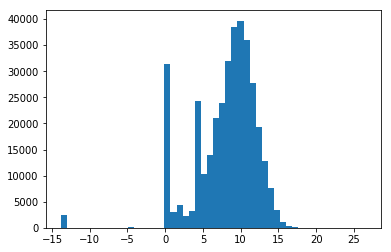

Field1129 : 501215 values


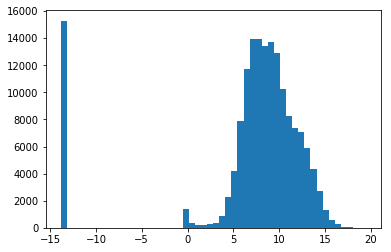

Field1522 : 599255 values


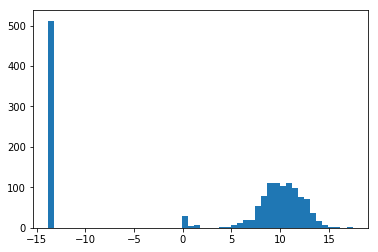

Field1631 : 593199 values


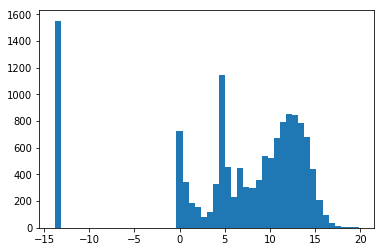

Field17 : 598183 values


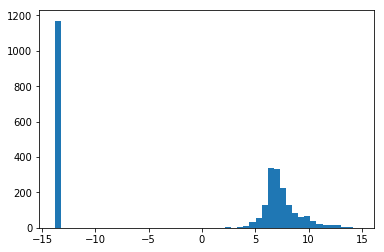

Field1865 : 416527 values


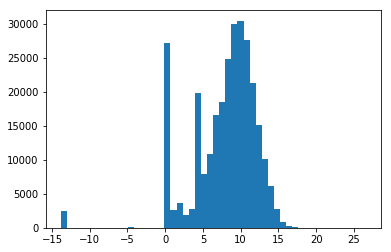

Field1871 : 584013 values


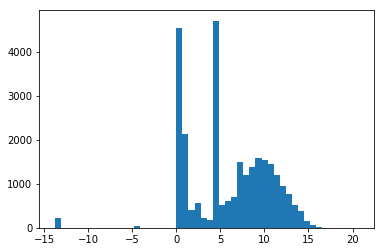

Field1885 : 397742 values


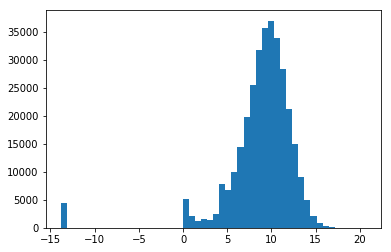

Field1977 : 599743 values


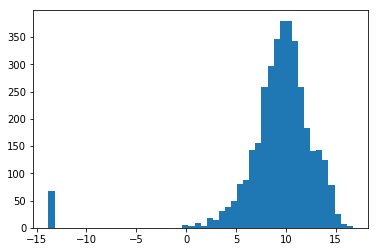

Field2298 : 599185 values


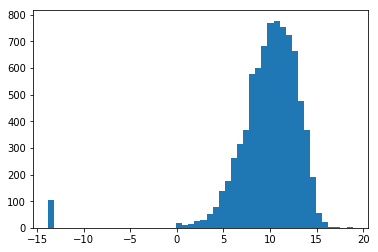

Field2304 : 599927 values


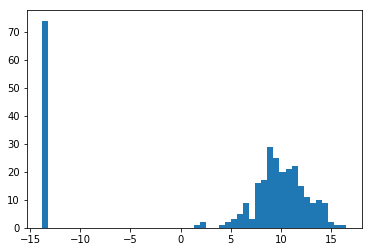

Field2316 : 537028 values


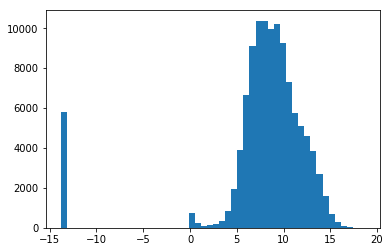

Field2447 : 599658 values


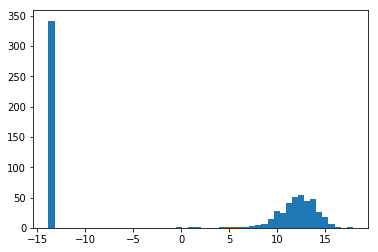

Field2483 : 599943 values


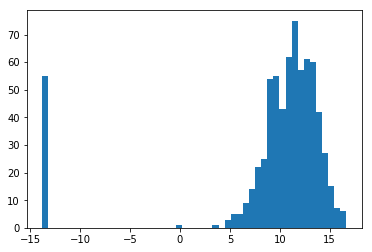

Field2497 : 585499 values


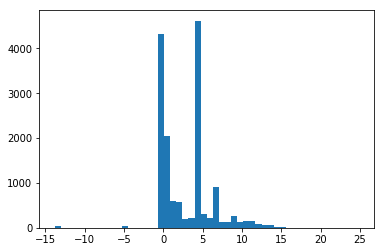

Field2502 : 583946 values


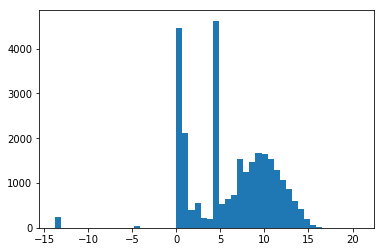

Field2815 : 599979 values


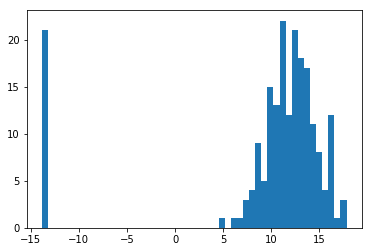

Field282 : 599568 values


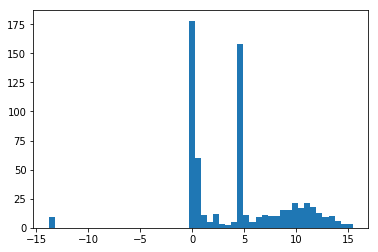

Field306 : 503245 values


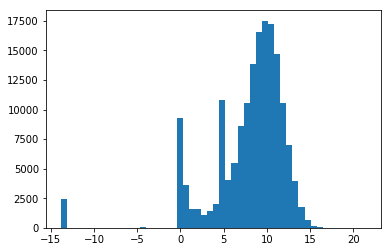

Field448 : 599749 values


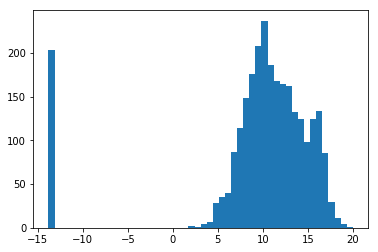

Field465 : 435301 values


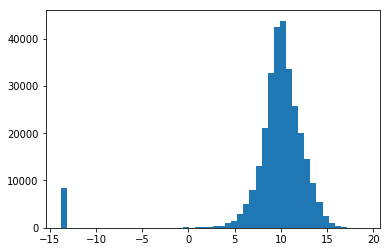

Field474 : 598045 values


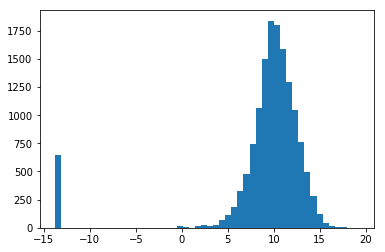

Field487 : 598339 values


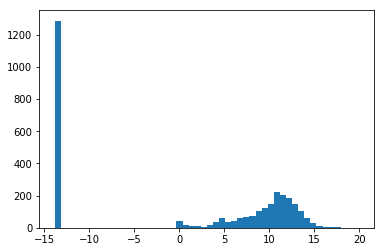

Field489 : 441938 values


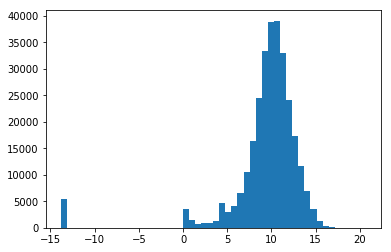

Field541 : 535566 values


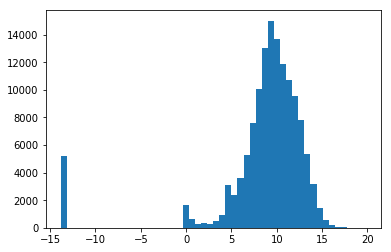

Field69 : 598659 values


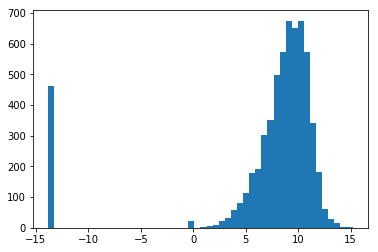

Field70 : 598726 values


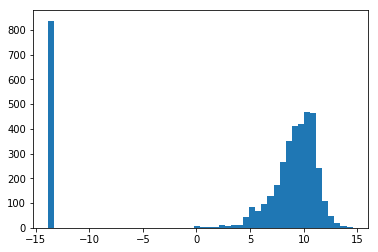

Field477 : 600000 values


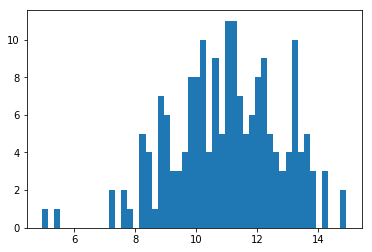

In [11]:
# Now examine the "good" accounting fields:
acc_field_names = ['Field' + str(n) for n in accounting_field_nums]
for field_name in acc_field_names:
    col_data = db[field_name].to_numpy()
    print(field_name, ':', len(np.unique(col_data)), 'values')
    col_data = np.log(col_data + 1.0e-6)  # plot on log scale
    plt.hist(col_data, bins=50)
    plt.show()

In [12]:
print("Columns in cleaned dataset:")
for col in clean_data.columns:
    # get num unique values of this col:
    numunique = -1
    
    try:
        numunique = len(np.unique(clean_data[col]))
    except TypeError:
        pass  # can occur when comparing None values
    
    print(col, ':', numunique, "unique value(s)")

Columns in cleaned dataset:
Field1014 : 360089 unique value(s)
Field1129 : 501215 unique value(s)
Field1522 : 599255 unique value(s)
Field1631 : 593199 unique value(s)
Field17 : 598183 unique value(s)
Field1865 : 416527 unique value(s)
Field1871 : 584013 unique value(s)
Field1885 : 397742 unique value(s)
Field1977 : 599743 unique value(s)
Field2298 : 599185 unique value(s)
Field2304 : 599927 unique value(s)
Field2316 : 537028 unique value(s)
Field2447 : 599658 unique value(s)
Field2483 : 599943 unique value(s)
Field2497 : 585499 unique value(s)
Field2502 : 583946 unique value(s)
Field2506 : 599675 unique value(s)
Field2616 : 599123 unique value(s)
Field2619 : 599740 unique value(s)
Field2705 : 422370 unique value(s)
Field2815 : 599979 unique value(s)
Field282 : 599568 unique value(s)
Field306 : 503245 unique value(s)
Field448 : 599749 unique value(s)
Field465 : 435301 unique value(s)
Field474 : 598045 unique value(s)
Field477 : 600000 unique value(s)
Field487 : 598339 unique value(s)
F

imd : 32477 unique value(s)
imdu_diff : 34820 unique value(s)


In [13]:
date_col_pred = get_col_matcher(date_cols)  # a predicate for date-based columns
cols = [col for col in db.columns if date_col_pred(col)]
date_data = clean_data[cols].sample(frac=10000.0/600000.0)  # only examine subset of data

Printing information about dates:


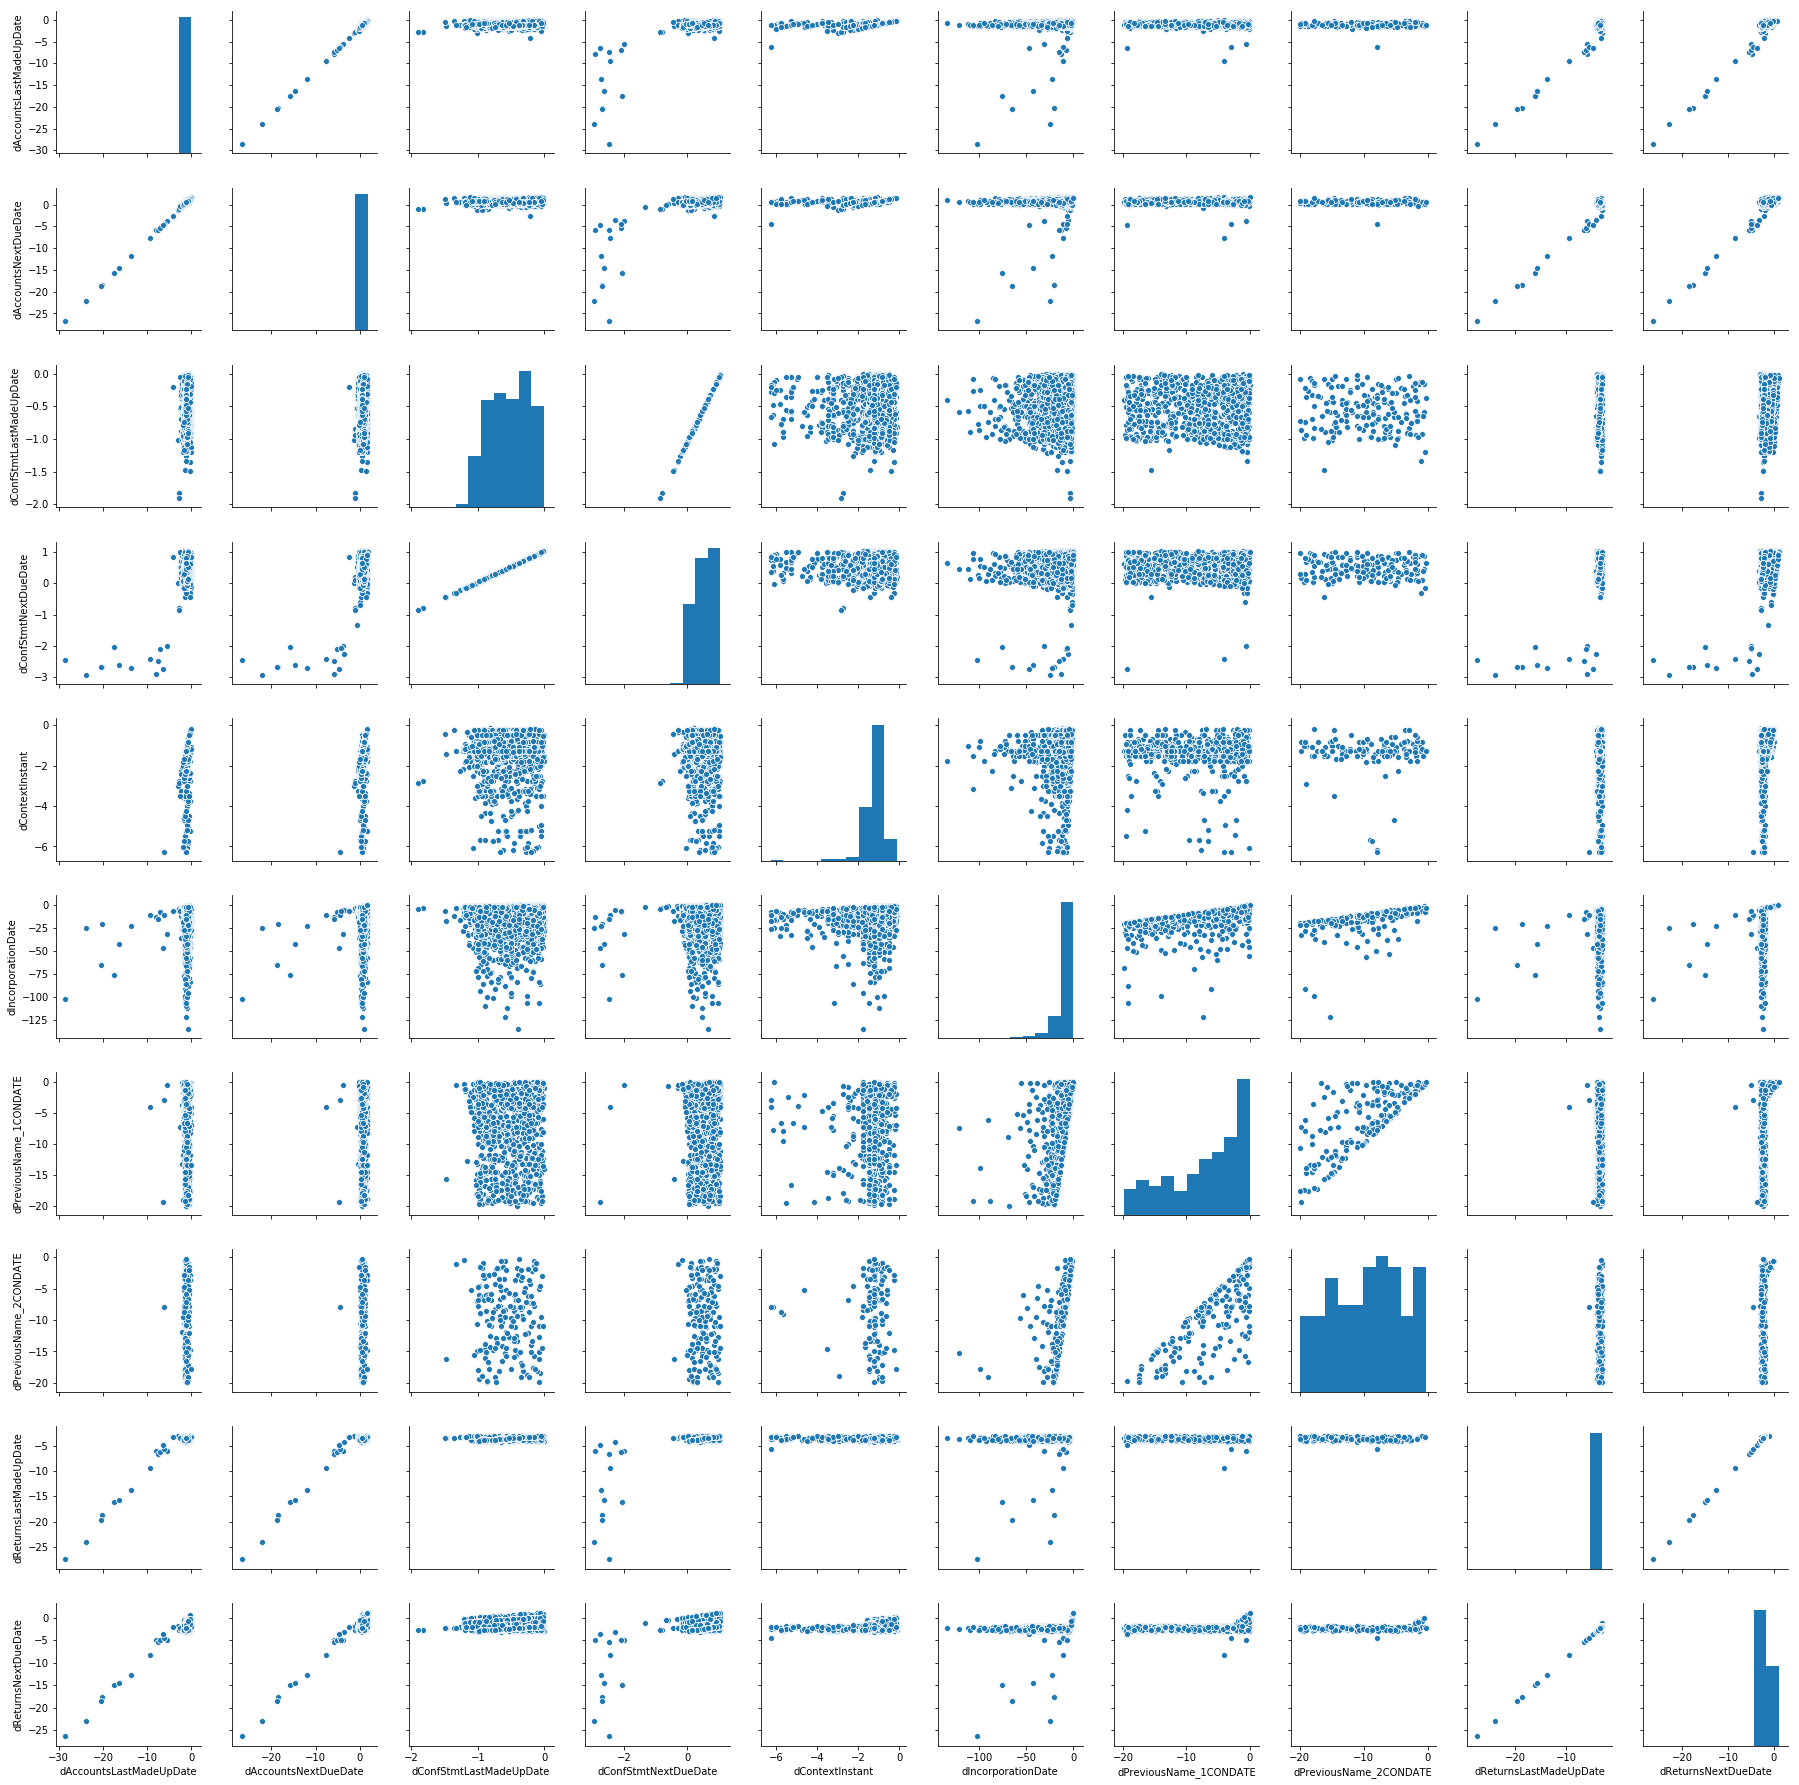

In [14]:
print("Printing information about dates:")
seaborn.pairplot(date_data)
plt.show()

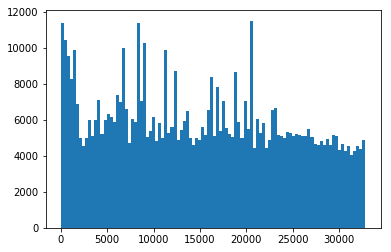

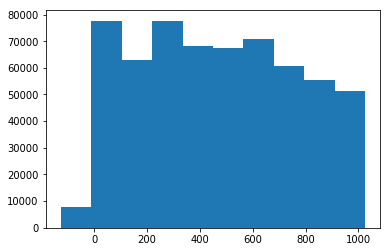

The cleaned version of the dataset has values derived from these columns.


In [28]:
# plot index of mass deprivation
plt.hist(db['imd'], label='imd', bins=100)
plt.show()
# plot the difference of these two fields (which tend to be very correlated):
plt.hist(db['imd'] - db['imdu'], label='diff', bins=10)
plt.show()

print("The cleaned version of the dataset has values derived from these columns.")

Graphically represent the IMD (index of mass deprivation) which is computed from position:


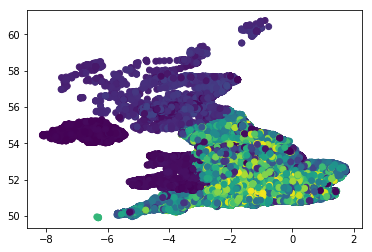

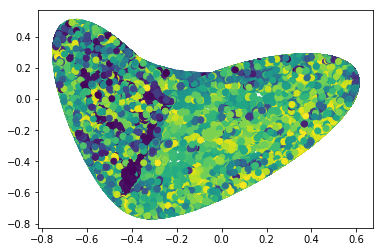

In [29]:
print("Graphically represent the IMD (index of mass deprivation) which is computed from position:")
plt.scatter(db['long'], db['lat'], c=db['imd']/max(db['imd']))
plt.show()
plt.scatter(clean_data['pos1'], clean_data['pos2'], c=db['imd']/max(db['imd']))
plt.show()